In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'bright', 'vpedre'])
from classy import Class

import os, json
os.chdir('../')
import python.vp_utils as utils

with open('output/lcdm/snap_026/snapshot_metadata.json') as f:
    metadata = json.load(f)

parameters_sim = utils.parameters_sim

In [2]:
C_ells_XY = np.load('output/lcdm/C_ells_XY.npy', allow_pickle=True).item()
ell_grid = np.load('output/lcdm/ell_grid.npy')

P_curl = np.load('output/lcdm/snap_026/Pk_curl.npy')
k_curl = np.load('output/lcdm/snap_026/k_curl.npy')
P_m = np.load('output/lcdm/snap_026/Pk_m.npy')
k_m = np.load('output/lcdm/snap_026/k_m.npy')

z=metadata['redshift']

factor = 6*parameters_sim['H0']**2*parameters_sim['Omega_m']*(1+z) 



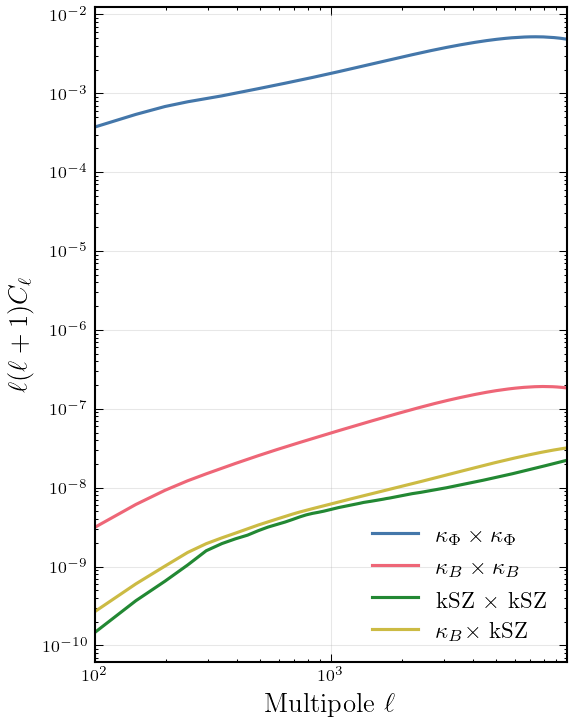

In [3]:
fig, ax = plt.subplots(figsize=(4, 5))

# Plot all spectra
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['Phi'],                 label=r"$\kappa_\Phi \times \kappa_\Phi$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['B']  ,       label=r"$\kappa_B \times \kappa_B$")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['kSZ']    ,   label=r"kSZ $\times$ kSZ")
ax.loglog(ell_grid, ell_grid*(ell_grid+1)*C_ells_XY['B_X_kSZ'],   label=r"$\kappa_B \times$ kSZ")

# Axis labels
ax.set_xlabel(r"Multipole $\ell$", fontsize=13)
ax.set_ylabel(r"$\ell(\ell+1)C_\ell$", fontsize=13)

# Legend
ax.legend(fontsize=11, loc="best", frameon=False)

# Grid and limits
# ax.grid(True, which="both", ls="--", lw=0.5, alpha=0.7)
ax.set_xlim(ell_grid.min(), ell_grid.max())

plt.tight_layout()
plt.savefig('imgs/C_ells.pdf')
plt.show()


In [4]:
CLASS = {}

# --- Cosmology parameters ---
params_base = {
    'output': 'tCl,sCl,lCl,mPk',
    'h': parameters_sim['h'],
    'Omega_cdm': parameters_sim['Omega_m'] - parameters_sim['Omega_b'],
    'Omega_b': parameters_sim['Omega_b'],
    'A_s': 2.1e-9,
    'n_s': 0.965,
    'tau_reio': 0.06,
    'modes': 's',
    'lensing': 'yes',
    'l_switch_limber': 50,
    'z_max_pk': 1080,
    'non_linear':'halofit',
    'P_k_max_1/Mpc' : '10'
}

# Constant z
params_const = params_base.copy()
params_const.update({'z_pk': '3.0'})

CLASS['const_z'] = Class()
CLASS['const_z'].set(params_const)
CLASS['const_z'].compute()

# Variable z
z_list = np.linspace(0.0, 3, 27)
params_var = params_base.copy()
params_var.update({'z_pk': ','.join([str(z) for z in z_list])})

CLASS['var_z'] = Class()
CLASS['var_z'].set(params_var)
CLASS['var_z'].compute()

# --- Define k grid (in 1/Mpc) ---
kk = np.geomspace(1e-4, 10., num=1000)

# --- Get P(k,z) at fixed z=3 ---
Pk_m_class_const_z = CLASS['const_z'].get_pk_all(kk, 3., nonlinear=True)

# --- Get P(k,z) at several z ---
z_list = [0, 0.1, 0.5, 1., 2., 3., 10., 100., 1080.]

Pk_m_class_varz = np.array([ CLASS['var_z'].get_pk_all(kk, z, nonlinear=True) for z in z_list])

Pk_m_class_varz_4interp = Pk_m_class_varz.T   # shape = (len(k_vals), len(z_list))

# --- Get lensing Cl from CLASS ---
# cl = CLASS['var_z'].lensed_cl()
cl_tot = CLASS['var_z'].raw_cl(2500)   # unlensed spectrum
cl_lensed = CLASS['var_z'].lensed_cl(2500)  # lensed spectrum

ells = cl_tot['ell']
Cl_pp_tot = cl_tot['pp']  # lensing potential power spectrum
Cl_kk_tot = .25 * (ells+2)*(ells+1)*ells*(ells-1) * Cl_pp_tot  # convergence spectrum

ells_lensed = cl_lensed['ell']
Cl_pp_lensed = cl_lensed['pp']  # lensing potential power spectrum
Cl_kk_lensed = .25 * (ells+2)*(ells+1)*ells*(ells-1) * Cl_pp_lensed  # convergence spectrum

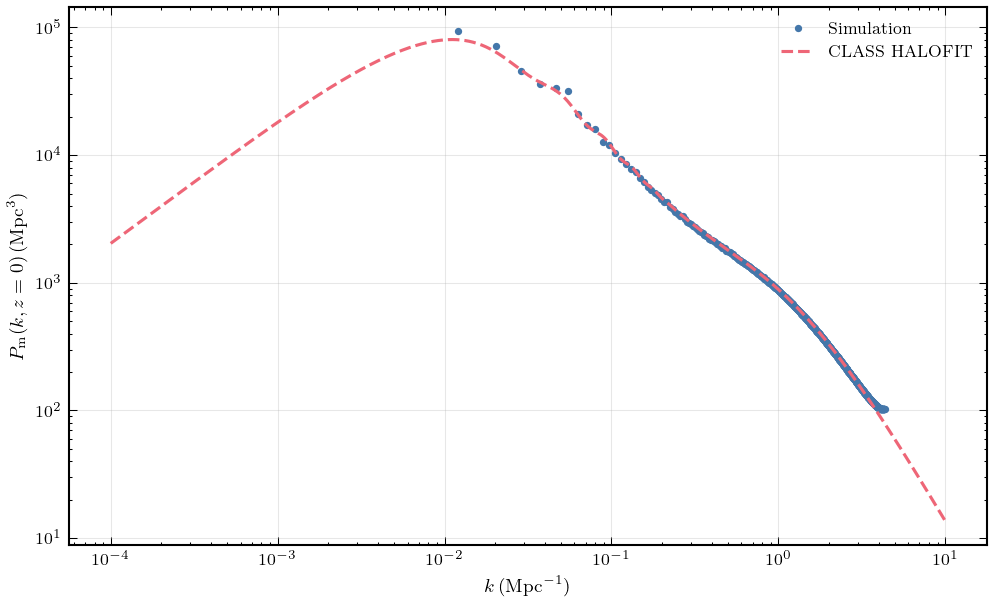

In [13]:
fig, ax = plt.subplots()

ax.loglog(k_m, P_m, '.', label='Simulation')
ax.loglog(kk, Pk_m_class_varz[0], '--', label='CLASS HALOFIT')

ax.set_xlabel(r'$k \,(\text{Mpc}^{-1})$')
ax.set_ylabel(r'$P_\text{m}(k,z=0) \,(\text{Mpc}^3$)')
ax.legend()

plt.tight_layout()
plt.savefig('imgs/matter_powerspec.pdf')

In [7]:
Pk_B = P_curl*factor**2 / k_curl**6 

Delta_B = Pk_B * k_curl**3 / (2*np.pi**2) / (parameters_sim['c']**6)

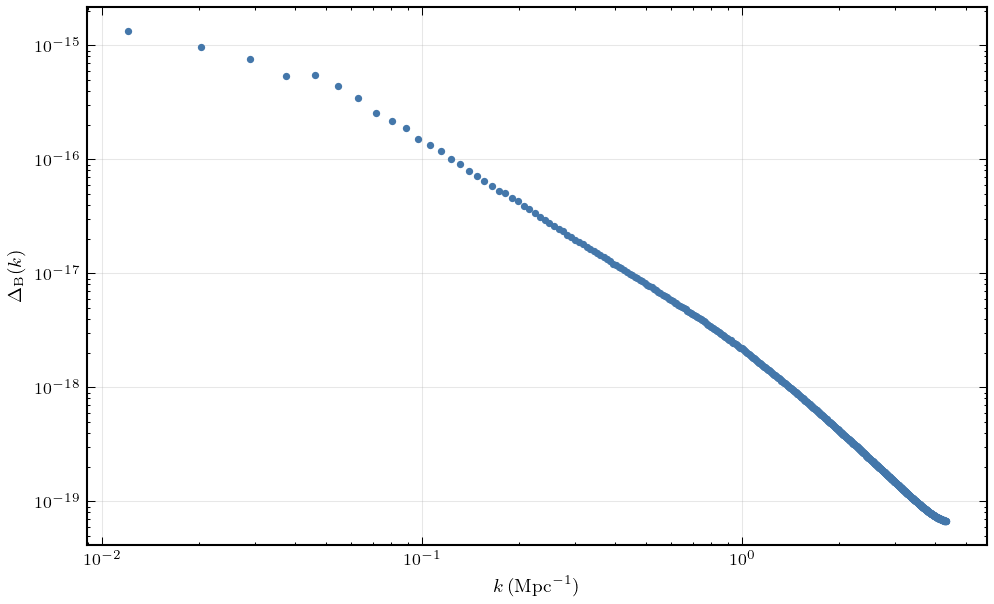

In [12]:
fig, ax = plt.subplots()

ax.loglog(k_curl, Delta_B, '.')
ax.set_xlabel(r'$k \,(\text{Mpc}^{-1})$')
ax.set_ylabel(r'$\Delta_\text{B}(k)$')

plt.tight_layout()
plt.savefig('imgs/momentum_powerspec.pdf')